# Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Get the Data

In [4]:
train_df = pd.read_csv("train.csv")
labels = pd.read_csv("labels.csv")

In [5]:
test_df = pd.read_csv("test.csv")

# Process Data

In [6]:
train_df.isna().any().sum()

7

In [7]:
cols_with_na = []
for col in train_df:
    if train_df[col].isna().any():
        cols_with_na.append(col)

In [8]:
cols_with_na

['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

In [9]:
train_df.dropna(axis="columns", inplace=True)

In [10]:
def change_date(df):
    for i in range(len(df)):
        new_date = df["date_recorded"][i][:4]
        df["date_recorded"][i] = new_date

In [11]:
change_date(train_df)

c:\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
train_df["date_recorded"]

0        2011
1        2013
2        2013
3        2013
4        2011
         ... 
59395    2013
59396    2011
59397    2011
59398    2011
59399    2011
Name: date_recorded, Length: 59400, dtype: object

In [25]:
train_df["ward"].value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Ikweha         1
Izia           1
Rasbura        1
Chinugulu      1
Kitete         1
Name: ward, Length: 2092, dtype: int64

In [36]:
train_df.drop(columns=["wpt_name", "ward"], inplace=True)

In [18]:
numeric_features = []
categorical_features = []

In [19]:
for col in train_df.columns:
    if train_df[col].dtype == object:
        categorical_features.append(col)
    else:
        numeric_features.append(col)

In [20]:
print(len(numeric_features) + len(categorical_features))

33


In [21]:
for feat in categorical_features:
    print(feat, len(np.unique(train_df[feat])))

date_recorded 5
wpt_name 37400
basin 9
region 21
lga 125
ward 2092
recorded_by 1
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6


In [41]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [42]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [44]:
labels["status_group"].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [45]:
labels["status_group"] = labels["status_group"].map({"non functional": 0, "functional": 1, "functional needs repair": 2})

In [46]:
full_df = pd.merge(train_df, labels, on="id")

In [47]:
train_features = [col for col in full_df.columns if col != "status_group"]

In [48]:
x_train, x_valid, y_train, y_valid = train_test_split(full_df[train_features], full_df["status_group"], test_size=0.1, random_state=42)

In [49]:
y_train.value_counts()

1    29062
0    20506
2     3892
Name: status_group, dtype: int64

In [50]:
preprocessor.fit(x_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['id', 'amount_tsh', 'gps_height', 'longitude',
                                  'latitude', 'num_private', 'region_code',
                                  'district_code', 'population',
                                  'construction_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  On...r(handle_unknown='ignore'))]),
                                 ['date_recorded', 'basin', 'region', 'lga',
                        

In [51]:
x_train_processed = preprocessor.transform(x_train).todense()

In [52]:
x_train_processed.shape

(53460, 297)

In [53]:
x_valid_processed = preprocessor.transform(x_valid).todense()

In [54]:
x_valid_processed.shape

(5940, 297)

# Sklearn LogReg Model

In [55]:
log_reg_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

In [56]:
log_reg_model.fit(x_train, y_train)

c:\miniconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'amount_tsh',
                                                   'gps_height', 'longitude',
                                                   'latitude', 'num_private',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('cat',
                         

In [57]:
print("model score: %.3f" % log_reg_model.score(x_train, y_train))
print("model score: %.3f" % log_reg_model.score(x_valid, y_valid))

model score: 0.749
model score: 0.747


In [58]:
log_reg_test_pred = log_reg_model.predict(test_df)

c:\miniconda3\envs\dev\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [59]:
log_reg_test_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [60]:
random_forest_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=300, min_samples_leaf=5, n_jobs=-1))])

In [61]:
random_forest_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'amount_tsh',
                                                   'gps_height', 'longitude',
                                                   'latitude', 'num_private',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('cat',
                         

In [62]:
print("model score: %.3f" % random_forest_model.score(x_train, y_train))
print("model score: %.3f" % random_forest_model.score(x_valid, y_valid))

model score: 0.823
model score: 0.796


In [63]:
random_forest_pred = random_forest_model.predict(test_df)

c:\miniconda3\envs\dev\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [64]:
random_forest_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

# Functions for Training

In [65]:
x_train_processed.shape

(53460, 297)

In [66]:
y_train.shape

(53460,)

In [67]:
y_train.isna().any()

False

In [68]:
y_train.value_counts()

1    29062
0    20506
2     3892
Name: status_group, dtype: int64

In [69]:
train_ds = TensorDataset(torch.from_numpy(np.squeeze(np.asarray(x_train_processed))).float(), 
                               torch.from_numpy(y_train.values).long())
valid_ds = TensorDataset(torch.from_numpy(np.squeeze(np.asarray(x_valid_processed))).float(), 
                               torch.from_numpy(y_valid.values).long())

In [70]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=True)

In [71]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
device

device(type='cuda', index=0)

In [157]:
def create_model():
    model = nn.Sequential(
        nn.Linear(297, 256),
        nn.ReLU(),
#         nn.Dropout(0.2),
        nn.Linear(256, 32),
        nn.ReLU(),
#         nn.Dropout(0.2),
        nn.Linear(32, 3)
    )
    return model

In [74]:
def validate(model, valid_dl, device="cpu"):
    total = 0
    correct = 0
    
    for inputs, labels in valid_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        value, pred = torch.max(model(inputs), 1)
        total+=len(labels)
        correct+=torch.sum(labels == pred)
    return correct*100./total

In [151]:
def train(model, train_dl, valid_dl, numb_epochs=5, learning_rate=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.4172437335414025, 7.4671120246659815]).float().to(device))
    loss_fn = nn.CrossEntropyLoss()
    
    train_accuracies = []
    valid_accuracies = []
    
    max_accuracy = -1
    
    for epoch in range(1, numb_epochs+1):
        losses = []
        total = 0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item() * len(labels))
            total+=len(labels)
        
        valid_accuracy = validate(model, valid_dl, device=device)
        train_accuracy = validate(model, train_dl, device=device)
        
        valid_accuracies.append(valid_accuracy)
        train_accuracies.append(train_accuracy)
        
        if valid_accuracy > max_accuracy:
            max_accuracy = valid_accuracy
            best_model = copy.deepcopy(model)
            print("Better Model")
            
        print(f"Epoch: {epoch} Training Loss: {np.sum(losses)/total} Training Accuracy: {train_accuracy} Validation Accuracy: {valid_accuracy}")
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(valid_accuracies, label="Validation Accuracy")
    plt.legend()
    return best_model

In [158]:
model = create_model()

Better Model
Epoch: 1 Training Loss: 0.6500702180489591 Training Accuracy: 75.8623275756836 Validation Accuracy: 75.5723876953125
Better Model
Epoch: 2 Training Loss: 0.5747177108280497 Training Accuracy: 77.51963806152344 Validation Accuracy: 76.96969604492188
Better Model
Epoch: 3 Training Loss: 0.5482837081446078 Training Accuracy: 78.41002655029297 Validation Accuracy: 77.4579086303711
Epoch: 4 Training Loss: 0.5333639614019241 Training Accuracy: 78.67190551757812 Validation Accuracy: 76.9528579711914
Better Model
Epoch: 5 Training Loss: 0.5209395016751573 Training Accuracy: 79.07968139648438 Validation Accuracy: 77.59259033203125
Better Model
Epoch: 6 Training Loss: 0.5109032292692482 Training Accuracy: 79.88402557373047 Validation Accuracy: 77.92929077148438
Epoch: 7 Training Loss: 0.5027365365725888 Training Accuracy: 79.8428726196289 Validation Accuracy: 77.67676544189453
Epoch: 8 Training Loss: 0.4964365402233097 Training Accuracy: 80.33483123779297 Validation Accuracy: 77.609

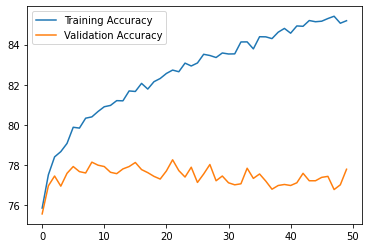

In [159]:
best_model = train(model, train_dl, valid_dl, 50, 1e-3, device=device)

## Save Model

In [93]:
torch.save(best_model.state_dict(), "best_model.pth")

## Load Model

In [94]:
best_model = create_model()
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

Sequential(
  (0): Linear(in_features=297, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=3, bias=True)
)

## Testing Model

In [101]:
test_df.drop(columns=cols_with_na, inplace=True)

In [102]:
change_date(test_df)

c:\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [104]:
test_df.drop(columns=["wpt_name", "ward"], inplace=True)

In [105]:
test_df.isna().any().sum()

0

In [106]:
test_df.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,basin,region,region_code,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013,1996,35.290799,-4.059696,0,Internal,Manyara,21,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013,1569,36.656709,-3.309214,0,Pangani,Arusha,2,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013,1567,34.767863,-5.004344,0,Internal,Singida,13,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013,267,38.058046,-9.418672,0,Ruvuma / Southern Coast,Lindi,80,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013,1260,35.006123,-10.950412,0,Ruvuma / Southern Coast,Ruvuma,10,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [107]:
test_data_processed = preprocessor.transform(test_df).todense()

In [108]:
test_data_processed

matrix([[ 0.63805574, -0.10371752,  1.91457448, ...,  0.        ,
          0.        ,  1.        ],
        [ 0.67747752, -0.10371752,  1.29845414, ...,  0.        ,
          0.        ,  0.        ],
        [-0.93027793, -0.10371752,  1.29556833, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.38998962, -0.10371752,  1.16426399, ...,  0.        ,
          0.        ,  0.        ],
        [-0.16871447, -0.10371752,  0.47455551, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.47417068, -0.10371752, -0.27142626, ...,  0.        ,
          0.        ,  0.        ]])

In [109]:
test_data_processed.shape

(14850, 297)

In [111]:
storage = torch.zeros(len(test_data_processed))

In [112]:
test_ds = TensorDataset(torch.from_numpy(np.squeeze(np.asarray(test_data_processed))).float(), storage.long())

In [113]:
test_dl = DataLoader(test_ds, batch_size=14850, shuffle=False)

In [114]:
def pred_test(model, test_dl):
    for inputs, _ in test_dl:
        inputs = inputs.to(device)
        model_pred = model(inputs)
        values, pred = torch.max(model_pred, 1)
        pred = pred.data.cpu()
        return pred

In [115]:
pred_test(best_model.to(device), test_dl)

tensor([1, 1, 1,  ..., 1, 1, 0])

In [116]:
test_preds = pred_test(best_model, test_dl)

In [117]:
test_preds

tensor([1, 1, 1,  ..., 1, 1, 0])

In [118]:
len(test_preds)

14850

In [119]:
from collections import Counter

In [120]:
def compare(test_preds, log_reg_test_pred, random_forest_pred):
    combined_pred = []
    for i in range(len(test_preds)):
        preds = []
        
        preds.append(test_preds[i].item())
        preds.append(log_reg_test_pred[i])
        preds.append(random_forest_pred[i])
        c = Counter(preds)
        
#         print(test_preds[i].item(), log_reg_test_pred[i], random_forest_pred[i], "ans:", c.most_common()[0][0])
        combined_pred.append(c.most_common()[0][0])
    return combined_pred

In [121]:
combined_pred = compare(test_preds, log_reg_test_pred, random_forest_pred)

In [122]:
combined_pred

[0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,


In [123]:
decoder = {
    0: "non functional",
    1: "functional",
    2: "functional needs repair"
}

decoded_test_preds = []
def decode(test_preds):
    for i in range(len(test_preds)):
        decoded_test_preds.append(decoder[test_preds[i]])

In [124]:
decode(combined_pred)

In [125]:
len(decoded_test_preds)

14850

In [126]:
decoded_test_preds

['non functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional needs repair',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'non functional',
 'functional needs repair',
 'non functional',
 'functional',
 

In [127]:
submission = pd.DataFrame({"id": test_df["id"], "status_group": decoded_test_preds}).to_csv("combined_submission.csv", index=False)